In [1]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, r2_score
import joblib

In [6]:
metadata_country_file = '../Metadata_Country_API_NY.GDP.MKTP.CD_DS2_en_csv_v2_19294.csv'

In [7]:
gdp_file = '../API_NY.GDP.MKTP.CD_DS2_en_csv_v2_19294.csv'
water_access_file = '../API_SH.H2O.BASW.ZS_DS2_en_csv_v2_28288/API_SH.H2O.BASW.ZS_DS2_en_csv_v2_28288.csv'
pop_density_file = '../API_EN.POP.DNST_DS2_en_csv_v2_19479/API_EN.POP.DNST_DS2_en_csv_v2_19479.csv'
urban_pop_file = '../API_SP.URB.TOTL.IN.ZS_DS2_en_csv_v2_19523/API_SP.URB.TOTL.IN.ZS_DS2_en_csv_v2_19523.csv'
sanitation_file = '../API_SH.STA.BASS.ZS_DS2_en_csv_v2_21825/API_SH.STA.BASS.ZS_DS2_en_csv_v2_21825.csv'
df_gdp = pd.read_csv(gdp_file)
df_water = pd.read_csv(water_access_file)
df_pop_density = pd.read_csv(pop_density_file)
df_urban_pop = pd.read_csv(urban_pop_file)
df_sanitation = pd.read_csv(sanitation_file)
df_metadata = pd.read_csv(metadata_country_file)

In [8]:
import pandas as pd
import numpy as np

def clean_dataset(df, value_column):
    #function to clean World Bank datasets
    # Keep only country-level data
    df = df[~df['Country Name'].str.contains('Africa|Asia|Europe|World|OECD|Aggregates', na=True)]
    
    # Remove unnecessary columns
    df = df.drop(columns=['Indicator Name', 'Indicator Code'])
    
    # Convert from wide to long format
    df = df.melt(
        id_vars=['Country Name', 'Country Code'],
        var_name='Year',
        value_name=value_column
    )
    
    # Clean data types
    df['Year'] = pd.to_numeric(df['Year'], errors='coerce')
    df[value_column] = pd.to_numeric(df[value_column].astype(str).str.replace(',', '').str.replace('%', ''), errors='coerce')
    
    # Drop missing values
    df = df.dropna(subset=[value_column])
    
    return df

# Clean all datasets
df_gdp_clean = clean_dataset(df_gdp, 'gdp')
df_pop_density_clean = clean_dataset(df_pop_density, 'pop_density')
df_urban_pop_clean = clean_dataset(df_urban_pop, 'urban_pop')
df_sanitation_clean = clean_dataset(df_sanitation, 'sanitation')
df_water_clean = clean_dataset(df_water, 'water_access')

# Merge all datasets
merged_df = df_gdp_clean.merge(df_pop_density_clean, 
                            on=['Country Name', 'Country Code', 'Year'],
                            how='inner')
merged_df = merged_df.merge(df_urban_pop_clean,
                          on=['Country Name', 'Country Code', 'Year'],
                          how='inner')
merged_df = merged_df.merge(df_sanitation_clean,
                          on=['Country Name', 'Country Code', 'Year'],
                          how='inner')
merged_df = merged_df.merge(df_water_clean,
                          on=['Country Name', 'Country Code', 'Year'],
                          how='inner')

# Final cleanup
merged_df = merged_df.rename(columns={'Country Name': 'country', 'Year': 'year'})
merged_df = merged_df[['country', 'year', 'gdp', 'pop_density', 'urban_pop', 'sanitation', 'water_access']]

# Example output (filter to specific years if needed)
final_data = merged_df[merged_df['year'] == 2020]

In [9]:
# Save to CSV
merged_df.to_csv("merged_data.csv", index=False)

In [10]:
merged_df

,country,year,gdp,pop_density,urban_pop,sanitation,water_access
0,Aruba,2000.0,1.873453e+09,503.266667,46.717,97.973104,94.488806
1,Afghanistan,2000.0,3.521418e+09,30.863847,22.078,20.970919,27.441856
2,Angola,2000.0,9.129595e+09,12.990189,50.087,27.557524,41.144310
3,Albania,2000.0,3.480355e+09,112.738212,41.741,89.488671,86.397044
4,Andorra,2000.0,1.432606e+09,139.755319,92.395,99.999999,99.999999
...,...,...,...,...,...,...,...
5119,Viet Nam,2022.0,4.103240e+11,318.032649,38.766,92.170340,97.956817
5120,Vanuatu,2022.0,1.022219e+09,25.680558,25.816,46.714933,91.337516
5121,Samoa,2022.0,8.329452e+08,77.432014,17.616,97.927864,99.037614
5122,Zambia,2022.0,2.916378e+10,27.109509,45.761,36.301369,68.247807


# Exploratory Data Analysis (EDA)


In [11]:
print("Data Overview")
print(merged_df.describe())

Data Overview
              year           gdp   pop_density    urban_pop   sanitation  \
count  5124.000000  5.124000e+03   5124.000000  5124.000000  5124.000000   
mean   2010.975605  1.452315e+12    364.365007    57.706707    72.842353   
std       6.530069  5.772063e+12   1800.084316    23.568786    28.799090   
min    2000.000000  1.396473e+07      0.136492     8.246000     2.793897   
25%    2005.000000  5.815440e+09     33.272890    38.021717    49.469402   
50%    2011.000000  2.794040e+10     76.601466    56.970500    85.611971   
75%    2017.000000  2.580330e+11    172.663417    77.183250    97.664375   
max    2022.000000  6.496126e+13  21530.000000   100.000000   100.000000   

       water_access  
count   5124.000000  
mean      85.739122  
std       17.614171  
min       18.682303  
25%       78.004927  
50%       93.799695  
75%       99.073809  
max      100.000000  


In [12]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5124 entries, 0 to 5123
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   country       5124 non-null   object 
 1   year          5124 non-null   float64
 2   gdp           5124 non-null   float64
 3   pop_density   5124 non-null   float64
 4   urban_pop     5124 non-null   float64
 5   sanitation    5124 non-null   float64
 6   water_access  5124 non-null   float64
dtypes: float64(6), object(1)
memory usage: 280.3+ KB


In [13]:
print("Missing Values: ")
print(merged_df.isnull().sum())

Missing Values: 
country         0
year            0
gdp             0
pop_density     0
urban_pop       0
sanitation      0
water_access    0
dtype: int64


In [14]:
merged_df.head()

,country,year,gdp,pop_density,urban_pop,sanitation,water_access
0,Aruba,2000.0,1.873453e+09,503.266667,46.717,97.973104,94.488806
1,Afghanistan,2000.0,3.521418e+09,30.863847,22.078,20.970919,27.441856
2,Angola,2000.0,9.129595e+09,12.990189,50.087,27.557524,41.144310
3,Albania,2000.0,3.480355e+09,112.738212,41.741,89.488671,86.397044
4,Andorra,2000.0,1.432606e+09,139.755319,92.395,99.999999,99.999999


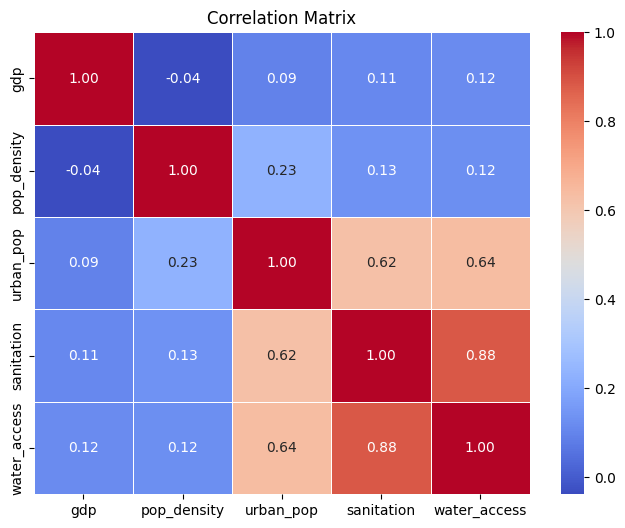

In [15]:
# Compute correlation matrix
corr = merged_df[['gdp', 'pop_density', 'urban_pop', 'sanitation', 'water_access']].corr()

# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

In [16]:
# Correlation analysis
plt.figure(figsize=(10, 8))
sns.heatmap(merged_df.select_dtypes(include=[np.number]).corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.savefig('correlation_matrix.png')
plt.close()
plt.show()


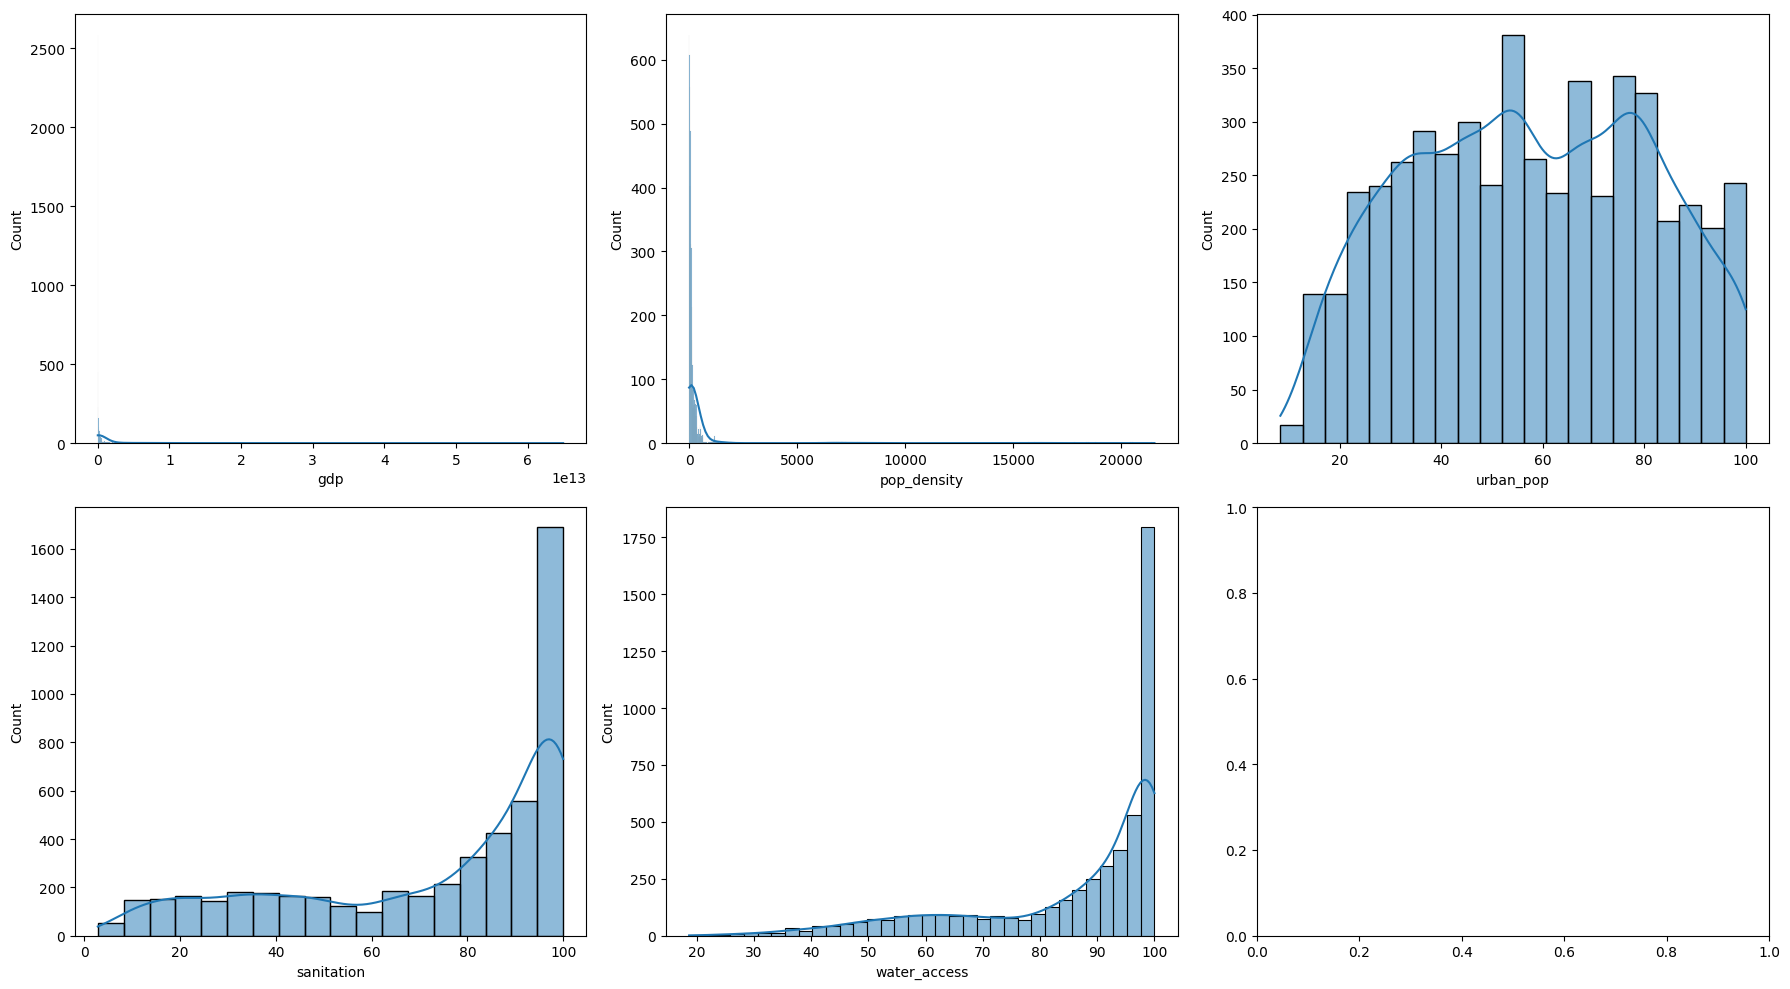

In [17]:
# Distribution plo
# Histogram with KDE
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
for i, col in enumerate(['gdp', 'pop_density', 'urban_pop', 'sanitation', 'water_access']):
    sns.histplot(merged_df[col], ax=axes[i//3, i%3], kde=True)
plt.tight_layout()
plt.show()

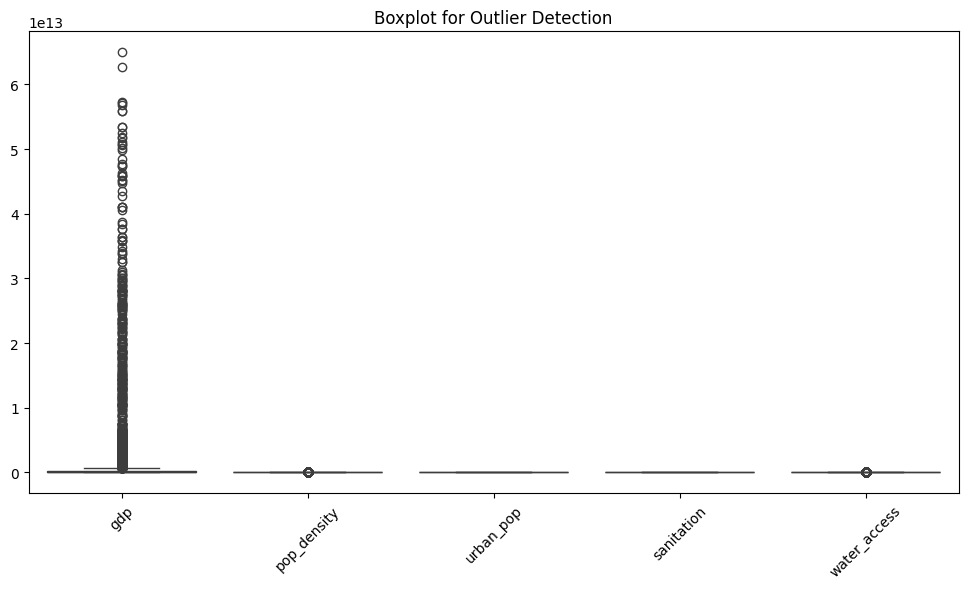

In [18]:
# Detection of Outliers using boxplot
plt.figure(figsize=(12, 6))
sns.boxplot(data=merged_df[['gdp', 'pop_density', 'urban_pop', 'sanitation', 'water_access']])
plt.xticks(rotation=45)
plt.title("Boxplot for Outlier Detection")
plt.show()

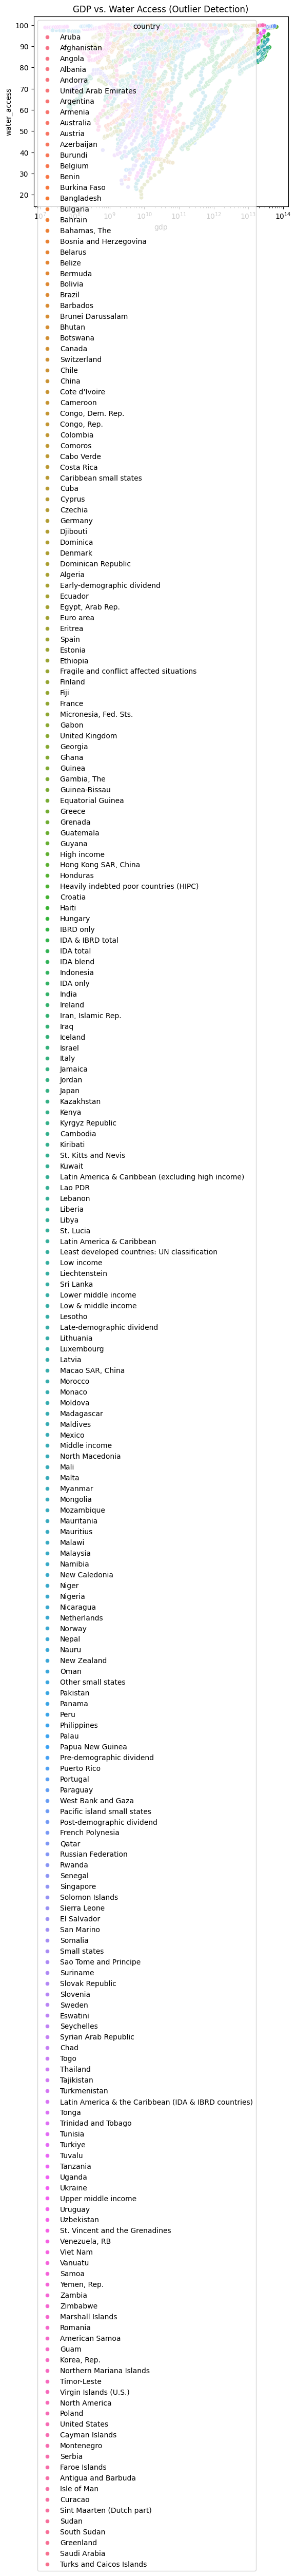

In [19]:
# as we can see the gdp have a have outlier 
sns.scatterplot(data=merged_df, x='gdp', y='water_access', hue='country')
plt.xscale('log')  # Use log scale for skewed data
plt.title("GDP vs. Water Access (Outlier Detection)")
plt.show()

In [20]:
def detect_outliers_iqr(column):
    Q1 = merged_df[column].quantile(0.25)
    Q3 = merged_df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = merged_df[(merged_df[column] < lower_bound) | (merged_df[column] > upper_bound)]
    return outliers

gdp_outliers = detect_outliers_iqr('gdp')
print(gdp_outliers[['country', 'year', 'gdp']])

                                                country    year           gdp
24                                               Brazil  2000.0  6.554482e+11
29                                               Canada  2000.0  7.447734e+11
32                                                China  2000.0  1.211332e+12
45                                              Germany  2000.0  1.966981e+12
51                           Early-demographic dividend  2000.0  3.377597e+12
...                                                 ...     ...           ...
5082                                       Saudi Arabia  2022.0  1.108571e+12
5105  Latin America & the Caribbean (IDA & IBRD coun...  2022.0  6.049067e+12
5110                                            Turkiye  2022.0  9.071184e+11
5115                                Upper middle income  2022.0  2.854707e+13
5117                                      United States  2022.0  2.600689e+13

[836 rows x 3 columns]


In [21]:
# Flag rows where any numeric column has a Z-score > 3 , which mean that they have extreme outliers
from scipy.stats import zscore

numeric_cols = ['gdp', 'pop_density', 'urban_pop', 'sanitation', 'water_access']
merged_df['zscore'] = merged_df[numeric_cols].apply(zscore).abs().max(axis=1)
extreme_outliers = merged_df[merged_df['zscore'] > 3]
print(extreme_outliers[['country', 'year', 'gdp', 'zscore']])

                        country    year           gdp     zscore
1                   Afghanistan  2000.0  3.521418e+09   3.310003
58                     Ethiopia  2000.0  8.242350e+09   3.807353
76                  High income  2000.0  2.805179e+13   4.608762
77         Hong Kong SAR, China  2000.0  1.716689e+11   3.324199
124            Macao SAR, China  2000.0  6.774194e+09  11.759283
...                         ...     ...           ...        ...
5054              North America  2022.0  2.817620e+13   4.630319
5076  Post-demographic dividend  2022.0  5.706675e+13   9.636045
5084                  Singapore  2022.0  4.984745e+11   4.159456
5115        Upper middle income  2022.0  2.854707e+13   4.694577
5117              United States  2022.0  2.600689e+13   4.254453

[262 rows x 4 columns]


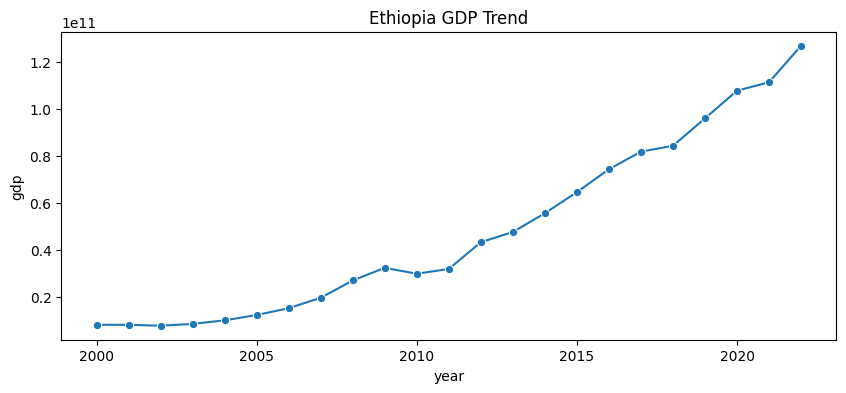

In [22]:
# Check GDP trends for outliers (e.g., USA)
country_trend = merged_df[merged_df['country'] == 'Ethiopia']
plt.figure(figsize=(10, 4))
sns.lineplot(data=country_trend, x='year', y='gdp', marker='o')
plt.title("Ethiopia GDP Trend")
plt.show()

C:\Users\NurselamHussen-ZOAEt\AppData\Local\Temp\ipykernel_10376\2982721610.py:7: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


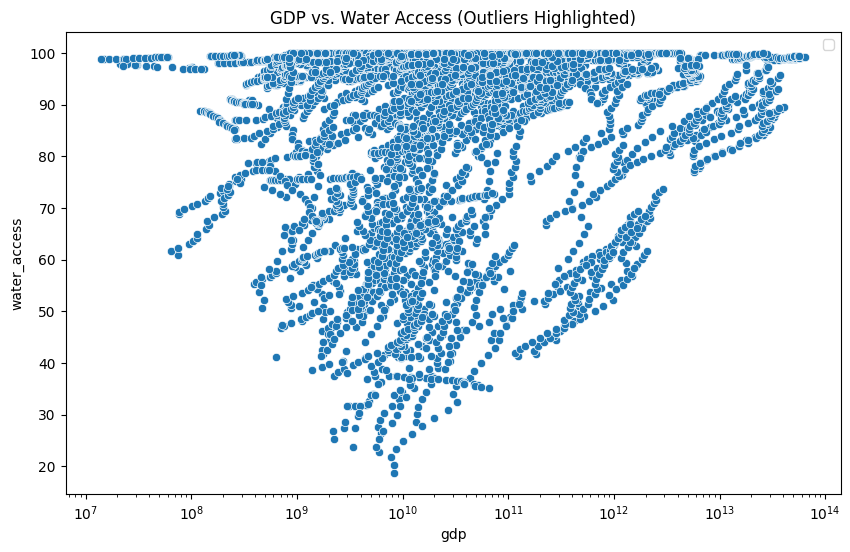

In [26]:
# Highlight GDP outliers
plt.figure(figsize=(10, 6))
sns.scatterplot(data=merged_df, x='gdp', y='water_access')
# sns.scatterplot(data=validated_outliers, x='gdp', y='water_access', color='red', label='Outliers')
plt.xscale('log')  # Use log scale for skewed data
plt.title("GDP vs. Water Access (Outliers Highlighted)")
plt.legend()
plt.show()

In [27]:
cleaned_df = merged_df.drop(extreme_outliers.index)

In [28]:
# Remove invalid GDP outliers (e.g., values < $1B for large countries)
valid_gdp_countries = merged_df[merged_df['gdp'] >= 1e9]

In [29]:
# Log transformation
merged_df['gdp_log'] = np.log1p(merged_df['gdp'])  # Handle zero values safely

In [55]:
# Feature Engineering
# Define features (X) and target (y)
# Use log-transformed GDP (`gdp_log`) instead of raw GDP (`gdp`)
X = merged_df[['gdp_log', 'pop_density', 'urban_pop', 'sanitation']]
y = merged_df['water_access']

In [56]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [30]:
from sklearn.model_selection import GroupShuffleSplit

# Step 1: Filter non-country entities
non_countries = ["Africa", "Asia", "World", "OECD", "Arab World"]
merged_df = merged_df[~merged_df['country'].str.contains("|".join(non_countries), na=True)]

# Step 2: Define features and target
X = merged_df[['gdp_log', 'pop_density', 'urban_pop', 'sanitation']]
y = merged_df['water_access']
groups = merged_df['country']

# Step 3: Grouped split (20% test size)
splitter = GroupShuffleSplit(test_size=0.2, n_splits=1, random_state=42)
train_idx, test_idx = next(splitter.split(X, y, groups=groups))

X_train = X.iloc[train_idx]
X_test = X.iloc[test_idx]
y_train = y.iloc[train_idx]
y_test = y.iloc[test_idx]

In [57]:
# Scaler the features
# Initial the Scaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [32]:
# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)  # Fit on training data
X_test_scaled = scaler.transform(X_test)    

In [33]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import joblib

# Train the model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train_scaled, y_train)

# Predict on test data
y_pred = model.predict(X_test_scaled)

# Evaluate performance
print("R²:", r2_score(y_test, y_pred))
print("MAE:", mean_absolute_error(y_test, y_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))

R²: 0.7363487175309138
MAE: 5.320477973311099
RMSE: 8.644001835757553


In [34]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5]
}

grid_search = GridSearchCV(RandomForestRegressor(random_state=42), param_grid, cv=5, scoring='r2')
grid_search.fit(X_train_scaled, y_train)

print("Best Parameters:", grid_search.best_params_)
print("Best R²:", grid_search.best_score_)

Best Parameters: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 100}
Best R²: 0.921395544622342


c:\Users\NurselamHussen-ZOAEt\Downloads\Data-EDA\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


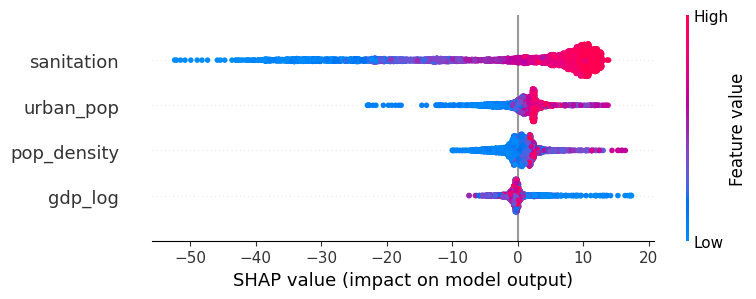

In [35]:
import shap

explainer = shap.TreeExplainer(grid_search.best_estimator_)
shap_values = explainer.shap_values(X_train_scaled)
shap.summary_plot(shap_values, X_train_scaled, feature_names=X.columns)

In [36]:
print("Training R²:", model.score(X_train_scaled, y_train))
print("Validation R²:", grid_search.best_score_)

Training R²: 0.9975368604508679
Validation R²: 0.921395544622342


In [ ]:
from sklearn.model_selection import cross_val_score

cv_scores = cross_val_score(grid_search.best_estimator_, X_scaled, y, cv=5, scoring='r2')
print("Cross-Validated R²:", np.mean(cv_scores))

In [ ]:
from xgboost import XGBRegressor

xgb_model = XGBRegressor(
    n_estimators=200,
    learning_rate=0.1,
    max_depth=5,
    random_state=42
)
xgb_model.fit(X_train_scaled, y_train)

print("XGBoost R²:", r2_score(y_test, xgb_model.predict(X_test_scaled)))

# Model Training

In [58]:
from sklearn.linear_model import LinearRegression

In [63]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

In [59]:
# Train with the Linear Regression
model = LinearRegression()
model.fit(X_train_scaled, y_train)

LinearRegression()

In [61]:
y_pred = model.predict(X_test_scaled)

In [64]:
print("R² Score:", r2_score(y_test, y_pred))
print("MAE:", mean_absolute_error(y_test, y_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))

R² Score: 0.8072782594182389
MAE: 5.335726774140904
RMSE: 7.886409158618223


In [31]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error

# Train
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train_scaled, y_train)

# Predict
y_pred = model.predict(X_test_scaled)

# Evaluate
print("R²:", r2_score(y_test, y_pred))
print("MAE:", mean_absolute_error(y_test, y_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))

NameError: name 'X_train_scaled' is not defined

In [71]:
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))

RMSE: 2.809894438539742


In [69]:
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

In [72]:
# Get feature importances
importances = model.feature_importances_
feature_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

print(feature_importance_df)

       Feature  Importance
3   sanitation    0.805351
2    urban_pop    0.080815
1  pop_density    0.068982
0      gdp_log    0.044852


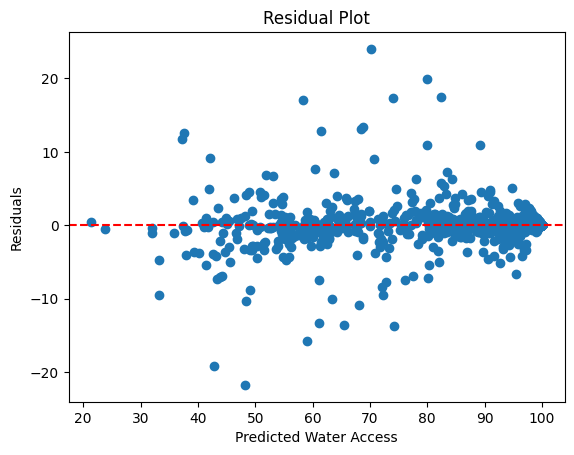

In [73]:
# residual analysis
# Checking patterns errors
residuals = y_test - y_pred
plt.scatter(y_pred, residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel("Predicted Water Access")
plt.ylabel("Residuals")
plt.title("Residual Plot")
plt.show()

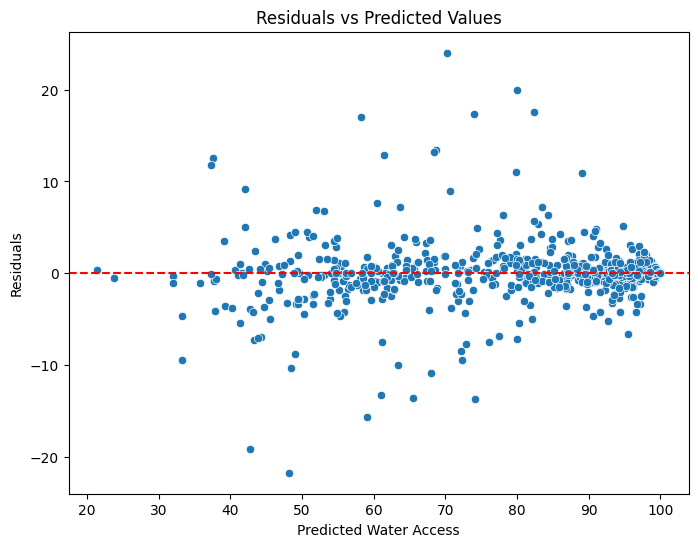

In [79]:
import matplotlib.pyplot as plt
import seaborn as sns

residuals = y_test - y_pred
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_pred, y=residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel("Predicted Water Access")
plt.ylabel("Residuals")
plt.title("Residuals vs Predicted Values")
plt.show()

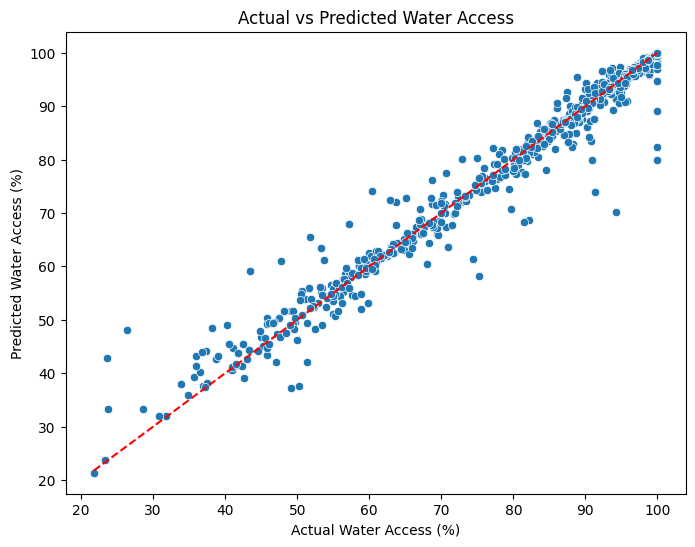

In [81]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual Water Access (%)")
plt.ylabel("Predicted Water Access (%)")
plt.title("Actual vs Predicted Water Access")
plt.show()

# Hyperparameter Tuning

In [74]:
# Optimize model parameters
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5]
}

grid_search = GridSearchCV(RandomForestRegressor(random_state=42), param_grid, cv=3, scoring='r2')
grid_search.fit(X_train_scaled, y_train)
print("Best Parameters:", grid_search.best_params_)

Best Parameters: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 200}


The model prioritizes accuracy over simplicity. Validate via cross-validation to ensure no overfitting.
n_estimators = 200 :
More trees improve robustness and reduce variance (slightly better than 100 trees).
Trade-off: Longer training time but stable performance.
max_depth = None :
Trees grow until leaves are pure, capturing complex patterns.
Risk: Potential overfitting (but validated by high test performance).
min_samples_split = 2 :
Splits nodes even with small samples, maximizing tree depth.

In [75]:
import shap
# Initialize the explainer
explainer = shap.TreeExplainer(model)

# Calculate SHAP values for the training data
shap_values = explainer.shap_values(X_train_scaled)

c:\Users\NurselamHussen-ZOAEt\Downloads\Data-EDA\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


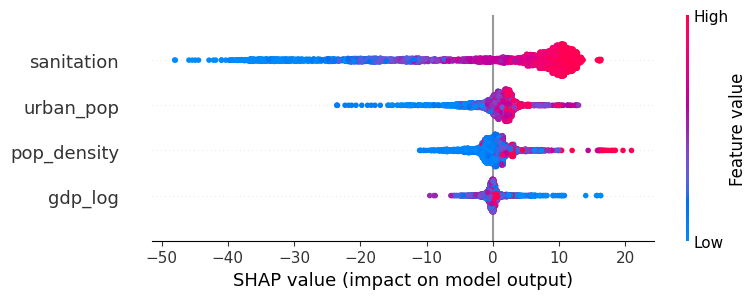

In [76]:
shap.summary_plot(shap_values, X_train_scaled, feature_names=X.columns)

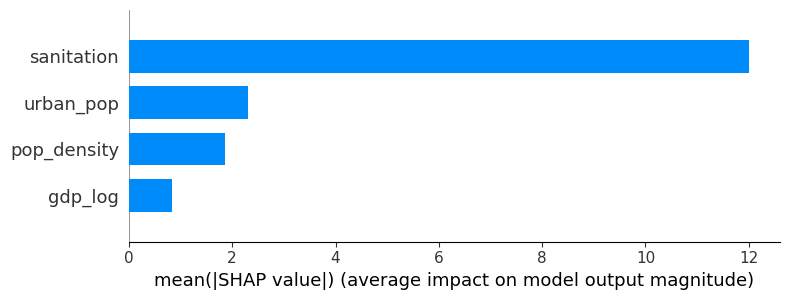

In [77]:
shap.summary_plot(shap_values, X_train_scaled, feature_names=X.columns, plot_type="bar")

# Save the Model

In [86]:
# Save the model using joblib
import joblib

# save the model
joblib.dump(model, 'water_access_model.joblib')
# save the scaler
joblib.dump(scaler, 'scaler.joblib')

['scaler.joblib']

In [1]:
import joblib
import numpy as np

model = joblib.load('final_water_access_model.joblib')
scaler = joblib.load('water_access_scaler.joblib')

test_cases = [
    [8.0, 100, 50, 70],   # Expected ~75–90%
    [10.0, 200, 80, 30],  # Expected lower due to sanitation
    [6.0, 50, 20, 90],    # Expected higher due to sanitation
]

for inputs in test_cases:
    input_scaled = scaler.transform([inputs])
    pred = model.predict(input_scaled)[0]
    print("Input:", inputs, "→ Prediction:", pred)

Input: [8.0, 100, 50, 70] → Prediction: 3.701161099250878
Input: [10.0, 200, 80, 30] → Prediction: 3.701161099250878
Input: [6.0, 50, 20, 90] → Prediction: 3.701161099250878


c:\Users\NurselamHussen-ZOAEt\Downloads\Data-EDA\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\NurselamHussen-ZOAEt\Downloads\Data-EDA\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\NurselamHussen-ZOAEt\Downloads\Data-EDA\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\NurselamHussen-ZOAEt\Downloads\Data-EDA\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\NurselamHussen-ZOAEt\Downloads\Data-EDA\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: U

In [2]:
import joblib
import numpy as np

# Load model and scaler
model = joblib.load('final_water_access_model.joblib')
scaler = joblib.load('water_access_scaler.joblib')

# Test cases
test_cases = [
    [8.0, 100, 50, 70],   # Expected: ~75–90%
    [10.0, 200, 80, 30],  # Expected: lower due to sanitation
    [6.0, 50, 20, 90],    # Expected: high due to sanitation
]

for inputs in test_cases:
    input_scaled = scaler.transform([inputs])
    pred_log = model.predict(input_scaled)[0]
    pred = np.expm1(pred_log)  # Invert log1p
    print(f"Input: {inputs} → Prediction: {pred:.2f}%")

Input: [8.0, 100, 50, 70] → Prediction: 39.49%
Input: [10.0, 200, 80, 30] → Prediction: 39.49%
Input: [6.0, 50, 20, 90] → Prediction: 39.49%


c:\Users\NurselamHussen-ZOAEt\Downloads\Data-EDA\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\NurselamHussen-ZOAEt\Downloads\Data-EDA\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\NurselamHussen-ZOAEt\Downloads\Data-EDA\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\NurselamHussen-ZOAEt\Downloads\Data-EDA\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\NurselamHussen-ZOAEt\Downloads\Data-EDA\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: U